In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats

In [2]:
# Load dataset and hero key file
df = pd.read_csv("datasets/picks_data.csv")
heros = {}

with open("datasets/heros.json") as hero_ids:
    heros_json = json.load(hero_ids)

for hero in heros_json:
    heros[hero['id']] = hero['name']

df.head()

,loosing_hero_id_1,loosing_hero_id_2,loosing_hero_id_3,loosing_hero_id_4,loosing_hero_id_5,winning_hero_id_1,winning_hero_id_2,winning_hero_id_3,winning_hero_id_4,winning_hero_id_5
0,18,28,43,75,84,60,71,74,87,93
1,47,72,78,86,107,11,12,30,38,51
2,21,51,65,71,73,13,63,66,80,89
3,11,26,83,93,110,8,22,33,90,97
4,15,16,21,26,99,7,11,47,93,102


In [3]:
# Separate winning and losing teams' heros
losers = df.iloc[:,:5]
winners = df.iloc[:,5:]

# Count all unique winning and losing heros
unique_losers, count_losers = np.unique(losers.to_numpy().flatten(), return_counts=True)
unique_winners, count_winners = np.unique(winners.to_numpy().flatten(), return_counts=True)

In [4]:
# Create dataframe for each hero with its win and pick rate
data = pd.DataFrame()
data['id'] = unique_losers
data['hero'] = [heros[i] for i in unique_losers]
data['wins'] = count_winners
data['losses'] = count_losers
data['total games'] = data['wins'] + data['losses']
data['popularity'] = data['total games']/df.shape[0]
data['win rate'] = data['wins']/data['total games']
data

,id,hero,wins,losses,total games,popularity,win rate
0,1,antimage,2485,2574,5059,0.070820,0.491204
1,2,axe,3094,3375,6469,0.090558,0.478281
2,3,bane,3086,3070,6156,0.086176,0.501300
3,4,bloodseeker,1290,1388,2678,0.037489,0.481703
4,5,crystal_maiden,3784,3616,7400,0.103591,0.511351
...,...,...,...,...,...,...,...
108,110,phoenix,1882,1924,3806,0.053279,0.494482
109,111,oracle,1331,1417,2748,0.038469,0.484352
110,112,winter_wyvern,2374,2369,4743,0.066396,0.500527
111,113,arc_warden,125,127,252,0.003528,0.496032


Getting the most picked heros gives an insight into the perceived strength of the hero

<AxesSubplot:title={'center':'Top 10 heros by popularity'}, xlabel='popularity', ylabel='hero'>

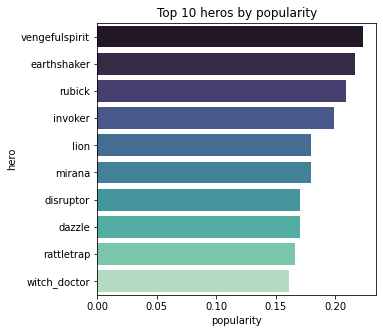

In [17]:
plt.figure(figsize=(5,5))
plt.title("Top 10 heros by popularity")
sns.barplot(x='popularity', y='hero', palette='mako', data=data.sort_values(by=['popularity'], ascending=False).iloc[0:10])

<AxesSubplot:title={'center':'Top 10 heros by win rate'}, xlabel='win rate', ylabel='hero'>

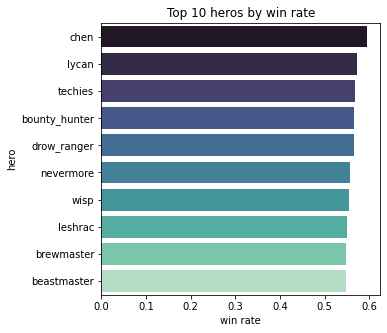

In [19]:
plt.figure(figsize=(5,5))
plt.title("Top 10 heros by win rate")
sns.barplot(x='win rate', y='hero', palette='mako', data=data.sort_values(by=['win rate'], ascending=False).iloc[0:10])

In [7]:
# Calculate the Pearson's r correlation coefficient between player 
# popularity and win rate
stats.pearsonr(data['popularity'], data['win rate'])

(-0.20070485321770554, 0.03304469711580285)

Based on the Pearson correlation coefficient, we can see that there is a small negative correlation between the hero pick rates (popularity) and the win rate of the hero. This leads us to believe that picking the most popular heros doesn't necessarily add to the win probability. Win rate depends more on the skill of the player and picking the correct counter for the opponent's roster.

<AxesSubplot:title={'center':'Hero popularity vs win rate'}, xlabel='popularity', ylabel='win rate'>

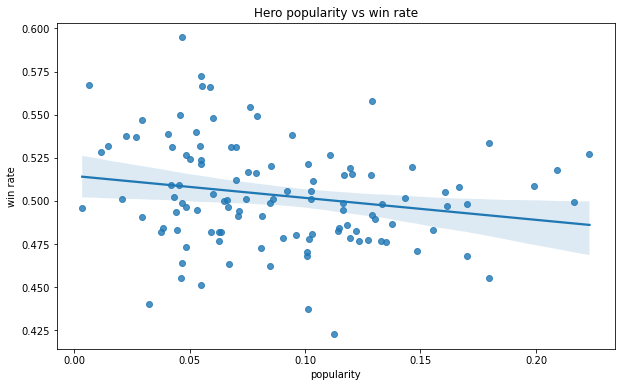

In [8]:
plt.figure(figsize=(10,6))
plt.title("Hero popularity vs win rate")
sns.regplot(x="popularity", y="win rate", data=data)

**Getting teams that won the most rounds**

In [9]:
# Restructure dataset and add a win status for each team composition
winners_team = winners.rename(columns = {'winning_hero_id_1': 'hero_1', 'winning_hero_id_2': 'hero_2', 'winning_hero_id_3': 'hero_3', 'winning_hero_id_4': 'hero_4', 'winning_hero_id_5': 'hero_5'})
winners_team['win'] = 1
losers_team = losers.rename(columns = {'loosing_hero_id_1': 'hero_1', 'loosing_hero_id_2': 'hero_2', 'loosing_hero_id_3': 'hero_3', 'loosing_hero_id_4': 'hero_4', 'loosing_hero_id_5': 'hero_5'})
losers_team['win'] = 0
teams = pd.DataFrame(columns=['hero_1', 'hero_2', 'hero_3', 'hero_4', 'hero_5', 'win'])
teams = pd.concat([teams, winners_team, losers_team])
teams = teams.astype('int32')
teams

,hero_1,hero_2,hero_3,hero_4,hero_5,win
0,60,71,74,87,93,1
1,11,12,30,38,51,1
2,13,63,66,80,89,1
3,8,22,33,90,97,1
4,7,11,47,93,102,1
...,...,...,...,...,...,...
71430,11,20,36,68,69,0
71431,42,85,89,99,111,0
71432,7,12,21,25,75,0
71433,44,53,64,71,74,0


In [10]:
# Get the most winning composition of teams
teams_cumulative = teams.groupby(teams.columns.to_list(), as_index=False).size()
winners_cumulative = teams_cumulative[(teams_cumulative['size'] > 1) & (teams_cumulative['win'] == 1)].rename(columns={'size':'wins'})
top_10_teams = winners_cumulative.sort_values(by='wins', ascending=False)[:10].drop(['win'], axis=1)

In [11]:
winners_cumulative

,hero_1,hero_2,hero_3,hero_4,hero_5,win,wins
299,1,3,28,47,50,1,2
710,1,7,11,50,55,1,2
714,1,7,11,50,71,1,3
728,1,7,11,71,112,1,2
781,1,7,15,20,51,1,2
...,...,...,...,...,...,...,...
139601,63,68,88,89,96,1,2
140349,68,74,80,84,93,1,2
140673,72,74,85,100,112,1,2
140674,72,74,86,92,98,1,2


**Top 10 team compositions based on wins**

In [12]:
top_10_teams_names = top_10_teams.replace({"hero_1": heros, "hero_2": heros, "hero_3": heros, "hero_4": heros ,"hero_5": heros})
top_10_teams_names

,hero_1,hero_2,hero_3,hero_4,hero_5,wins
94155,vengefulspirit,witch_doctor,beastmaster,luna,lycan,6
66195,nevermore,dark_seer,spirit_breaker,gyrocopter,winter_wyvern,4
129420,faceless_void,rattletrap,ancient_apparition,invoker,nyx_assassin,4
24870,crystal_maiden,pugna,dragon_knight,furion,abaddon,4
53112,mirana,tiny,batrider,treant,wisp,4
114654,slardar,dazzle,night_stalker,abaddon,elder_titan,4
46716,juggernaut,lion,tidehunter,tinker,skywrath_mage,3
122513,enigma,templar_assassin,luna,dark_seer,rubick,3
32632,earthshaker,nevermore,rattletrap,gyrocopter,disruptor,3
61832,nevermore,puck,night_stalker,jakiro,troll_warlord,3


**Fitting a linear and KNN classifier to predict win/loss based on team composition**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = teams.drop('win', axis=1)
y = teams['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegressionCV(solver='lbfgs', random_state=6220).fit(X_train, y_train)
clf.score(X_test, y_test)

0.505681155362684

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test, y_test)

0.5081775973495719

We can see that the dataset isn't really structured to help classification.